In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "CPP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52236] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/1634664448/sm_segment.MacBook-Pro-de-Genereux.501.616f0000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,2537,MA_16729g0010,MCGSERTLLVDSVRTFGRSVSSSPKNNMAGQSAASSSNTATNWTSQ...,130,0
1,1896,Pp3c22_5870V3.2.p,MVNVEKPHMSVAVLGHGDWAMIPSSSSHEPQQQTQQHQQEKKASQL...,394,0
2,1962,Medtr1g014820.1,MTSSNPTSSINVTTTDHNPNSSNDKMYRGVRKRKWGKWVSEIRLPN...,266,0
3,1648,CCG026244.2,MKVPSNGFLPNFADGERKCINSELWHACAGPLVSLPPVGSLVVYFP...,1106,0
4,2093,ONIVA04G20480.1,MGSGGGGCGRNGAVRQYIRSKVPRLRWTGELHCSFVQAIEFLGGQD...,306,0


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2558 non-null   int64 
 1   id          2558 non-null   object
 2   sequence    2558 non-null   object
 3   length      2558 non-null   int64 
 4   class       2558 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 100.1+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AE,AF,AH,AM,AN,AQ,AS,AW,AY,CD,...,YH,YK,YL,YN,YP,YS,YT,YV,YW,YY
0,0.002047,0.000000,0.000000,0.007165,0.006141,0.00000,0.013306,0.0,0.000000,0.000000,...,0.001024,0.0,0.002047,0.001024,0.001024,0.001024,0.002047,0.0,0.0,0.000000
1,0.000000,0.000000,0.002160,0.002160,0.002160,0.00216,0.006479,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,0.003361,0.001681,0.001681,0.001681,0.006723,0.00000,0.008403,0.0,0.001681,0.003361,...,0.000000,0.0,0.000000,0.000000,0.000000,0.001681,0.000000,0.0,0.0,0.000000
3,0.007519,0.002506,0.000000,0.000000,0.002506,0.00000,0.007519,0.0,0.002506,0.007519,...,0.002506,0.0,0.005013,0.000000,0.002506,0.002506,0.000000,0.0,0.0,0.005013
4,0.003300,0.001650,0.000000,0.008251,0.006601,0.00165,0.004950,0.0,0.001650,0.003300,...,0.000000,0.0,0.000000,0.000000,0.000000,0.003300,0.001650,0.0,0.0,0.000000


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 200)
X_test: (640, 200)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 22s 721ms/step - accuracy: 0.4844 - loss: 0.6932

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5783 - loss: 0.6886   

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6428 - loss: 0.6810 - val_accuracy: 0.9570 - val_loss: 0.5227


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.5309

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.3752 - val_accuracy: 0.9727 - val_loss: 0.0895


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1302

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0805 - val_accuracy: 0.9766 - val_loss: 0.0724


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0381

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0568 - val_accuracy: 0.9746 - val_loss: 0.0619


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0567

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0437 - val_accuracy: 0.9785 - val_loss: 0.0620


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.0833

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0400 - val_accuracy: 0.9805 - val_loss: 0.0528


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0124

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0246 - val_accuracy: 0.9805 - val_loss: 0.0517


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0158

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0248 - val_accuracy: 0.9785 - val_loss: 0.0527


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0040

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0211 - val_accuracy: 0.9805 - val_loss: 0.0482


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0162

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0121 - val_accuracy: 0.9727 - val_loss: 0.0631


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1176

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0192 - val_accuracy: 0.9824 - val_loss: 0.0513


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0072 - val_accuracy: 0.9805 - val_loss: 0.0570


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0072

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0191 - val_accuracy: 0.9727 - val_loss: 0.0776


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0040

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0083 - val_accuracy: 0.9727 - val_loss: 0.0850


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0091 - val_accuracy: 0.9727 - val_loss: 0.0761


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.0707e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0047 - val_accuracy: 0.9766 - val_loss: 0.0740


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0011

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0163 - val_accuracy: 0.9727 - val_loss: 0.0936


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0042

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0073 - val_accuracy: 0.9785 - val_loss: 0.0724


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.8771e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9727 - val_loss: 0.0870


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0044

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9746 - val_loss: 0.0916


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0010

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0096 - val_accuracy: 0.9746 - val_loss: 0.0978



[Train Accuracy: 99.90% - Test Accuracy: 97.19%]


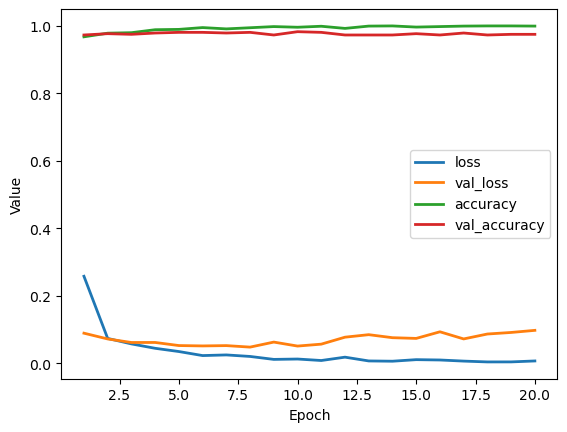

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,YCE,CEC,CLK,CNC,LYC,CFA,CRC,KYC,NCK,KKS,...,LKE,YHD,HTV,DMI,VGV,MAY,LSN,TPP,LPT,HPP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,0.003367,0.003367,0.003367,0.003367,0.001684,0.001684,0.0,0.001684,0.003367,0.001684,...,0.001684,0.0,0.0,0.0,0.0,0.001684,0.000000,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.002513,0.0,0.0,0.000000
4,0.003306,0.003306,0.003306,0.003306,0.001653,0.001653,0.0,0.001653,0.001653,0.001653,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001653


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2558, 1000)
X_test: (640, 1000)
y_train: (2558,)
y_test: (640,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20s 675ms/step - accuracy: 0.4688 - loss: 0.6932

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5783 - loss: 0.6916   

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6454 - loss: 0.6877 - val_accuracy: 0.9648 - val_loss: 0.6032


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9531 - loss: 0.6070

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.5317 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9716 - loss: 0.4793 - val_accuracy: 0.9863 - val_loss: 0.0812


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0425

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0542 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0500 - val_accuracy: 0.9902 - val_loss: 0.0454


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0067

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0228 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9913 - loss: 0.0221 - val_accuracy: 0.9883 - val_loss: 0.0275


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0035

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0180 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0172 - val_accuracy: 0.9883 - val_loss: 0.0258


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0036

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0081 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0076 - val_accuracy: 0.9863 - val_loss: 0.0332


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0042

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0064 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0061 - val_accuracy: 0.9902 - val_loss: 0.0323


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.3177e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0036     

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.9922 - val_loss: 0.0292


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0031

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0030 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 0.9902 - val_loss: 0.0293


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.8771e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.7036e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.2776e-04 - val_accuracy: 0.9922 - val_loss: 0.0330


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.3105e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.7453e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.8066e-04 - val_accuracy: 0.9922 - val_loss: 0.0347


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 8.0731e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.5365e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.6952e-04 - val_accuracy: 0.9883 - val_loss: 0.0387


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0010 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1867e-04 - val_accuracy: 0.9902 - val_loss: 0.0328


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.3778e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8234e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.5660e-04 - val_accuracy: 0.9922 - val_loss: 0.0345


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.1711e-04

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6695e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4720e-04 - val_accuracy: 0.9883 - val_loss: 0.0417


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.9983e-04

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0839e-04 - val_accuracy: 0.9922 - val_loss: 0.0397


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.9784e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4743e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6382e-04 - val_accuracy: 0.9902 - val_loss: 0.0367


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 9.3132e-05

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3428e-04 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5716e-04 - val_accuracy: 0.9902 - val_loss: 0.0385



[Train Accuracy: 100.00% - Test Accuracy: 99.53%]


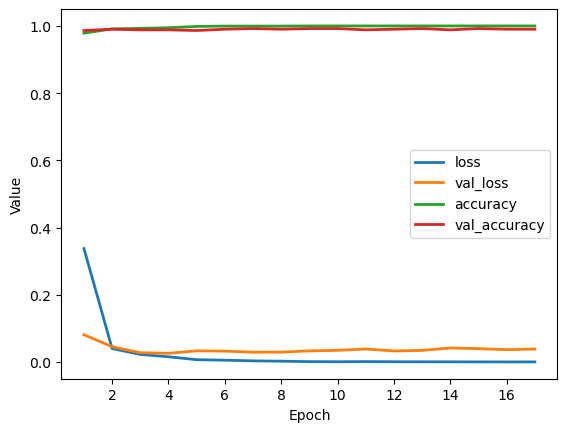

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAEI,AAGI,AAGL,AAGV,AAIT,AAKT,AANA,AARA,ACKR,ACQD,...,YNNV,YQAN,YQGG,YQSG,YRGM,YRGV,YRPL,YRSL,YRSP,YRSS
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.001686,0.0,0.001686,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001686,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.001656,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001656,0.000000,0.0,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 17s 563ms/step - accuracy: 0.4219 - loss: 0.6931

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5235 - loss: 0.6899   

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5473 - loss: 0.6874 - val_accuracy: 0.9746 - val_loss: 0.6196


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.6219

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9475 - loss: 0.5622 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 0.5408 - val_accuracy: 0.9727 - val_loss: 0.2163


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.2678

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 0.1814 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9731 - loss: 0.1719 - val_accuracy: 0.9785 - val_loss: 0.0652


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1150

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0860 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9777 - loss: 0.0811 - val_accuracy: 0.9785 - val_loss: 0.0538


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0149

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0719 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.0691 - val_accuracy: 0.9785 - val_loss: 0.0605


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0068

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0482 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0464 - val_accuracy: 0.9883 - val_loss: 0.0314


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0671

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0370 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0360 - val_accuracy: 0.9902 - val_loss: 0.0282


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0090

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0354 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.0341 - val_accuracy: 0.9961 - val_loss: 0.0223


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0068

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0319 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0306 - val_accuracy: 0.9883 - val_loss: 0.0276


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0039

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0181 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9961 - val_loss: 0.0179


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0186

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0197 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0211 - val_accuracy: 0.9961 - val_loss: 0.0171


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0056

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0181 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0176 - val_accuracy: 0.9961 - val_loss: 0.0183


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0514

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0275 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0253 - val_accuracy: 0.9961 - val_loss: 0.0198


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0080

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0097 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0101 - val_accuracy: 0.9980 - val_loss: 0.0157


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0079

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0118 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9980 - val_loss: 0.0155


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0037

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0133 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0136 - val_accuracy: 0.9980 - val_loss: 0.0174


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0045

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0072 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.9980 - val_loss: 0.0167


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0209

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0133 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9980 - val_loss: 0.0159


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0181

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0074 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0077 - val_accuracy: 0.9961 - val_loss: 0.0185


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0061 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0068 - val_accuracy: 0.9922 - val_loss: 0.0224


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0540

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0293 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0256 - val_accuracy: 0.9980 - val_loss: 0.0171


Epoch 22/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0032 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0041 - val_accuracy: 0.9980 - val_loss: 0.0151


Epoch 23/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0013

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0029 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0030 - val_accuracy: 0.9980 - val_loss: 0.0150


Epoch 24/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0110

23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0072 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9941 - val_loss: 0.0204



[Train Accuracy: 99.80% - Test Accuracy: 99.06%]


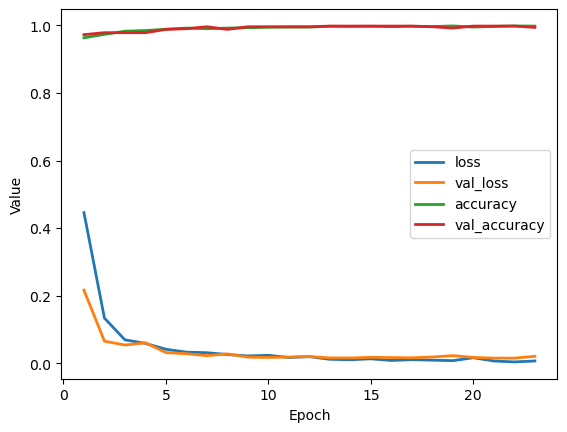

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAVS,AAGIY,AAGLY,AAGVY,AAITG,AAKTL,AANAA,AARAY,AARRE,AAVNG,...,YLADP,YLQQA,YLRPD,YNNVE,YQANV,YQGGV,YRGVR,YRPLL,YRSLL,YRSPL
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.001689,0.0,0.001689,0.0,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001689,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.001658,0.0,0.0,0.0,0.000000,0.0,0.001658,0.0,0.000000,0.001658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001658,0.000000,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - accuracy: 0.5938 - loss: 0.6931

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5571 - loss: 0.6919   

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5364 - loss: 0.6890

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5355 - loss: 0.6888 - val_accuracy: 0.5508 - val_loss: 0.6372


Epoch 2/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7188 - loss: 0.6302

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6934 - loss: 0.6085 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7474 - loss: 0.5707 - val_accuracy: 0.9805 - val_loss: 0.3528


Epoch 3/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.3839

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.3343 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.3049 - val_accuracy: 0.9668 - val_loss: 0.1197


Epoch 4/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.1399

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9667 - loss: 0.1258 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9670 - loss: 0.1226

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9672 - loss: 0.1218 - val_accuracy: 0.9805 - val_loss: 0.0657


Epoch 5/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0282

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0780 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.0817

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9808 - loss: 0.0821 - val_accuracy: 0.9824 - val_loss: 0.0538


Epoch 6/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.1584

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9711 - loss: 0.0926 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9750 - loss: 0.0831

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9754 - loss: 0.0818 - val_accuracy: 0.9844 - val_loss: 0.0477


Epoch 7/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0191

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.0566 

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9843 - loss: 0.0652

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.0658 - val_accuracy: 0.9844 - val_loss: 0.0479


Epoch 8/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0180

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.0615 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9849 - loss: 0.0597

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9850 - loss: 0.0592 - val_accuracy: 0.9922 - val_loss: 0.0402


Epoch 9/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0742

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9853 - loss: 0.0609 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.0584

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9860 - loss: 0.0579 - val_accuracy: 0.9824 - val_loss: 0.0579


Epoch 10/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0427

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9892 - loss: 0.0440 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.0516

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.0520 - val_accuracy: 0.9883 - val_loss: 0.0408


Epoch 11/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0657

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9796 - loss: 0.0704 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0684

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9820 - loss: 0.0685 - val_accuracy: 0.9824 - val_loss: 0.0737


Epoch 12/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0460

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0575 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9856 - loss: 0.0572

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0570 - val_accuracy: 0.9863 - val_loss: 0.0440


Epoch 13/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0935

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.0717 

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0609

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9877 - loss: 0.0588 - val_accuracy: 0.9922 - val_loss: 0.0358


Epoch 14/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0090

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9906 - loss: 0.0346 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9895 - loss: 0.0419

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9894 - loss: 0.0424 - val_accuracy: 0.9941 - val_loss: 0.0369


Epoch 15/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0279

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9897 - loss: 0.0556 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0512

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9901 - loss: 0.0512 - val_accuracy: 0.9941 - val_loss: 0.0333


Epoch 16/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0701

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0456 

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0424

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9912 - loss: 0.0425 - val_accuracy: 0.9941 - val_loss: 0.0387


Epoch 17/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0268

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0403 

28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9892 - loss: 0.0510

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9886 - loss: 0.0524 - val_accuracy: 0.9941 - val_loss: 0.0353


Epoch 18/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0269

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0418 

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0401

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0402 - val_accuracy: 0.9941 - val_loss: 0.0326


Epoch 19/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0136

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0261 

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - loss: 0.0314

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9943 - loss: 0.0320 - val_accuracy: 0.9941 - val_loss: 0.0324


Epoch 20/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0163

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9903 - loss: 0.0547 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.0514

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9904 - loss: 0.0509 - val_accuracy: 0.9941 - val_loss: 0.0323


Epoch 21/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0711

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0348 

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0352

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0352 - val_accuracy: 0.9941 - val_loss: 0.0332


Epoch 22/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0256

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0213 

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0250

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9941 - loss: 0.0262 - val_accuracy: 0.9941 - val_loss: 0.0323


Epoch 23/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0876

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0498 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9897 - loss: 0.0467

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9898 - loss: 0.0464 - val_accuracy: 0.9902 - val_loss: 0.0361


Epoch 24/100


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0070

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9914 - loss: 0.0426 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0419

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9915 - loss: 0.0417 - val_accuracy: 0.9941 - val_loss: 0.0320



[Train Accuracy: 99.17% - Test Accuracy: 98.59%]


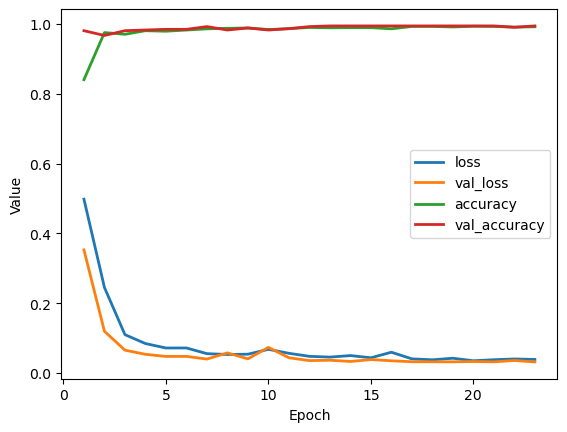

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


Report saved as Output/Reports/CPP/report_full_UTD057DV.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################